# Solving a 1st-order ODE IVP with a neural network

## Setup

In [1]:
%%javascript
MathJax.Hub.Config({
      TeX: { equationNumbers: { autoNumber: "AMS" } }
    });MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

In [2]:
from math import exp, cos, sin
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Introduction

This notebook will demonstrate how to use the code in the `nnode1.py` module. The module allows the user to solve 1st-order ordinary differential equation (ODE) initial value problems (IVPs) using a single-hidden layer neural network.

This work is based on the paper "Artificial Neural Networks for Solving Ordinary and Partial Differential Equations", by Lagaris et al, *IEEE Transactions on Neural Networks, Volume 9, No. 5*, September 1998. Note that the notation used in this notebook and the associated Python code is slightly different from that used in the Lagaris paper.

## The algorithm

Any 1st-order ODE can be written in the form:

\begin{equation}
G(x,y,\frac {dy}{dx}) = 0
\end{equation}

The problem is to find a solution $y(x)$ to the ODE using a neural network, subject to the initial condition:

\begin{equation}
y(0) = A
\end{equation}

The network is trained using a set of *training points*, defined on the domain of interest. The training points need not be evenly-spaced. Note that only the independent variable values $x_i$ of the training points are needed - the estimated value of the solution at those training points is obtained using a trial solution. For 1st-order ODE IVP, the trial solution has the form:

\begin{equation}
y_t(x_i) = A(x_i) + P(x_i)N(x_i,\vec p)
\end{equation}

For 1st-order ODE IVP, the forms for $A(x_i)$ and $P(x_i)$ are particularly simple:

\begin{equation}
A(x_i)=A
\end{equation}

\begin{equation}
P(x_i)=x_i
\end{equation}

The trial solution can be written more compactly as:

\begin{equation}
y_{ti} = A_i+P_i N_i
\end{equation}

where $y_{ti}=y_t(x_i,\vec p)$ is the value of the trial solution at the current training point $x_i$, $A_i=A$ is the initial condition ($y(0)$), $P_i=P(x_i)$ is the coefficient function for $N_i$, and $N_i=N(x_i,\vec p)$ is the single-valued floating-point output from an unspecified neural network with parameters $\vec p$. Note that this trial solution satisfies the initial condition by construction - at $x=0$, the second term vanishes, leaving $y_t(0)=A$.

Training is done in a set of *epochs*. A training epoch consists of presenting the neural network with each of the $n$ training points $x_i$, one at a time. For each input value $x_i$, the network output $N_i$ is computed, and used to compute the value of the trial solution $y_{ti}$. Once all $n$ points have been presented, the epoch is complete, and the error function $E$ is computed. The ODE definition (1) should vanish at convergence, and so an appropriate form for the error function is:

\begin{equation}
E = \sum_{j=1}^{n}G_i^2
\end{equation}

where $G_i$ is:

\begin{equation}
G_i = G(x_i,y_{ti},\frac {\partial y_{ti}}{\partial x_i})
\end{equation}

where $\frac {\partial y_{ti}}{\partial x_i}$ is the derivative of the trial function with respect to $x$, evaluated at $x_i$. This derivative is the current approximation of the analytical derivative $\frac {dy}{dx}$. Once this error function is computed, the weights and biases in the neural network are adjusted to reduce the error. Eventually, a minimum of $E$ is attained, and the resulting final form of $y_t(x)$ is used as the solution to the original ODE.

## Computing the network output $N_i$

The neural network used in this work has a simple structure. A single input node is used to provide the training data. The input node is fully-connected to a set of $H$ hidden nodes. Each hidden node is connected to a single output node.

During each step of a training epoch, the input to the network, and thus the output of the single input node, is just the training point $x_i$. This single output is then sent to each of the $H$ hidden nodes. At each hidden node $k$, the input value $x_i$ is transformed by the equation:

\begin{equation}
z_{ik} = w_k x_i + u_k
\end{equation}

where $z_{ik}$ is the transformed input at hidden node $k$, $w_k$ is the weight at node $k$, and $u_k$ is the bias at node $k$. This transformed value is then used as the input to a sigmoidal transfer function:

\begin{equation}
\sigma_{ik} = \sigma(z_{ik})
\end{equation}

where:

\begin{equation}
\sigma(z) = \frac {1}{1+e^{-z}}
\end{equation}

A plot of this transfer function and its first several derivatives is provided below.

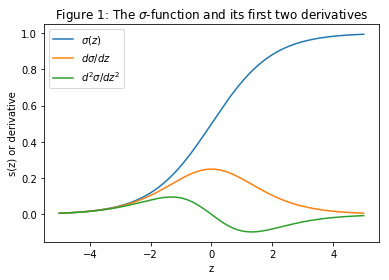

In [3]:
def sigma(z):
    return 1 / (1 + exp(-z))

def dsigma_dz(z):
    return exp(-z) / (1 + exp(-z))**2

def d2sigma_dz2(z):
    return (
        2 * exp(-2 * z) / (1 + exp(-z))**3 - exp(-z) / (1 + exp(-z))**2
    )

z = np.linspace(-5, 5, 1001)
n = len(z)
s = np.zeros(n)
ds_dz = np.zeros(n)
d2s_dz2 = np.zeros(n)
for i in range(n):
    s[i] = sigma(z[i])
    ds_dz[i] = dsigma_dz(z[i])
    d2s_dz2[i] = d2sigma_dz2(z[i])
plt.plot(z,s,label = "$\sigma(z)$")
plt.plot(z,ds_dz,label = "$d\sigma/dz$")
plt.plot(z,d2s_dz2, label = "$d^2\sigma/dz^2$")
plt.xlabel("z")
plt.ylabel("s(z) or derivative")
plt.title("Figure 1: The $\sigma$-function and its first two derivatives")
plt.legend();

Once the $\sigma_{ik}$ are computed, they are all passed to the single output node, where they are summed by a linear transfer function to create the network output for the current value of $x_i$:

\begin{equation}
N_i = \sum_{k=1}^{H}v_k\sigma_{ik}
\end{equation}

where $v_k$ is the weight applied to the signal from hidden node $k$ at the output node. Once $N_i$ has been computed, the trial function $y_{ti}$ and its derivative $\frac {\partial y_{ti}}{\partial x_i}$ is computed, and then the value of the ODE $G_i$ is computed, and finally the error function $E$.

## Updating the network parameters

The network parameters are the weights and biases of the hidden and output nodes. For a set of $H$ hidden nodes, we have a total of $N_p = 3H$ parameters in total: a weight and bias for each hidden node, and an output weight for each hidden node.

Since the objective function to minimize is the error $E$, the value of each network parameter $p$ (where $p$ represents $v_k$, $u_k$, or $w_k$) is updated using a scaled, simplified Newton's method:

\begin{equation}
p_{new}=p - \eta \frac {\partial E}{\partial p_j}
\end{equation}

where $\eta$ is the *learning rate* (usually $\eta < 1$). This simplified method (ignoring the usual 2nd derivative in the denominator of the correction term) is appropriate when the problem is scaled to the domain $\{0,1\}$.The learning rate is used to reduce the chance of solution instability due to large values of the correction term. The derivatives of $E$ are computed using the known form of the network and internal parameters.

This process of parameter updates is repeated until convergence is achieved (an error minimum is reached), or until the specified maximum number of training epochs have been applied. Note that the same set of training points is presented during each epoch.

## Computing the derivatives of $E$

The partial derivative of $E$ with respect to any network parameter $p$ is given by:

\begin{equation}
\frac {\partial E}{\partial p} =
\frac {\partial}{\partial p} \sum_{i=1}^{n}G_i^2 =
2 \sum_{i=1}^n G_i \frac {\partial G_i}{\partial p}
\end{equation}

## Computing the derivatives of $G_i$

The partial derivative of $G_i$ with respect to any network parameter $p$ is computed using the chain rule:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial}{\partial p} G(x_i,y_{ti},\frac {\partial y_{ti}}{\partial x_i}) =
\sum_{i=1}^n \left ( \frac {\partial G_i}{\partial x_i} \frac {\partial x_i}{\partial p} \right ) +
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\sum_{i=1}^n \frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}} \frac {\partial^2 y_{ti}}{\partial p \partial x_i}
\end{equation}

Since the training points $x_i$ are independent of the network parameters $\vec p$, this equation simplifies to:

\begin{equation}
\frac {\partial G_i}{\partial p} =
\frac {\partial G_i}{\partial y_{ti}} \frac {\partial y_{ti}}{\partial x_i} +
\sum_{i=1}^n \frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}} \frac {\partial^2 y_{ti}}{\partial p \partial x_i}
\end{equation}

The analytical forms of $\frac {\partial G_i}{\partial y_{ti}}$ and $\frac {\partial G_i}{\partial \frac {\partial y_{ti}}{\partial x_i}}$ are determined from the analytical form of the original ODE.

## Computing the derivatives of $y_{ti}$

The generic form of the derivatives of $y_{ti}$ is:

\begin{equation}
\frac {\partial y_{ti}}{\partial x_i} =
\frac {\partial A_i}{\partial x_i} +
P_i \frac {\partial N_i}{\partial x_i} + \frac {\partial P_i}{\partial x_i} N_i
\end{equation}

In the current case, $A_i$ is constant, and $P_i=x_i$, so we are left with:

\begin{equation}
\frac {\partial y_{ti}}{\partial x_i} =
x_i \frac {\partial N_i}{\partial x_i} + N_i
\end{equation}

The second partial of $y_{ti}$ is then:

\begin{equation}
\frac {\partial^2 y_{ti}}{\partial p \partial x_i} =
x_i \frac {\partial^2 N_i}{\partial p \partial x_i} + \frac {\partial N_i}{\partial p}
\end{equation}

## Computing the derivatives of $N_i$

The generic form of the derivative of $N_i$ with respect to $x_i$ is:

\begin{equation}
\frac {\partial N_i}{\partial x_i} =
\frac {\partial}{\partial x_i} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \frac {\partial \sigma_{ik}}{\partial z_{ik}} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial x_i} =
\sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k
\end{equation}

where the transfer function derivatives are defined by:

\begin{equation}
\sigma^{(n)} = \frac {\partial^n \sigma}{\partial z^n}
\end{equation}

For the parameter derivatives:

\begin{equation}
\frac {\partial N_i}{\partial p} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik} =
\sum_{k=1}^H \left ( v_k \frac {\partial \sigma_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial z_{ik}}{\partial p} + \frac {\partial v_k}{\partial p} \sigma_{ik}  \right )
\end{equation}

For the cross-partials:

\begin{equation}
\frac {\partial^2 N_i}{\partial p \partial x_i} =
\frac {\partial}{\partial p} \sum_{k=1}^H v_k \sigma_{ik}^{(1)} w_k =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \frac {\partial \sigma_{ik}^{(1)}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right ) =
\sum_{k=1}^H \left ( v_k \sigma_{ik}^{(1)} \frac {\partial w_k}{\partial p} +
v_k \sigma_{ik}^{(2)} \frac {\partial z_{ik}}{\partial p}  w_k +
\frac {\partial v_k}{\partial p} \sigma_{ik}^{(1)} w_k \right )
\end{equation}

## Computing the derivatives of $z_{ik}$

The derivatives of $z_k$ with respect to the network parameter $p$ are parameter-specific:

\begin{equation}
\frac {\partial z_{il}}{\partial v_k} = 0
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial u_k} = \delta_{kl}
\end{equation}

\begin{equation}
\frac {\partial z_{il}}{\partial w_k} = x_i \delta_{kl}
\end{equation}

## Computing the derivatives of the parameters $\vec p$

At this lowest level, the parameter derivatives are simple in form:

\begin{equation}
\frac {\partial v_l}{\partial v_k} = \delta_{kl}, \frac {\partial v_l}{\partial u_k} = 0, \frac {\partial v_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial u_l}{\partial v_k} = 0, \frac {\partial u_l}{\partial u_k} = \delta_{kl}, \frac {\partial u_l}{\partial w_k} = 0
\end{equation}

\begin{equation}
\frac {\partial w_l}{\partial v_k} = 0, \frac {\partial w_l}{\partial u_k} = 0, \frac {\partial w_l}{\partial w_k} = \delta_{kl}
\end{equation}

Or, more succinctly:

\begin{equation}
\frac {\partial p_l}{\partial p_k} = \delta_{kl}
\end{equation}

# Walking through an example problem

We will now walk through a complete problem which will illustrate how to use the `nnode1` code to solve a 1st-order ODE IVP.

## Define the ODE to solve, and the boundary conditions

Consider the simple 1st-order ODE IVP, defined on the range $[0,1]$:

\begin{equation}
G(x,y,\frac {dy}{dx}) = x-y = 0
\end{equation}

The analytical solution to this equation is simply:

\begin{equation}
y(x) = x
\end{equation}

This equation is implemented in the file `ode00.py`. The analytical solution and its derivative are shown in the figure below.

In [4]:
def ya(x):
    return x

def dya_dx(x):
    return 1

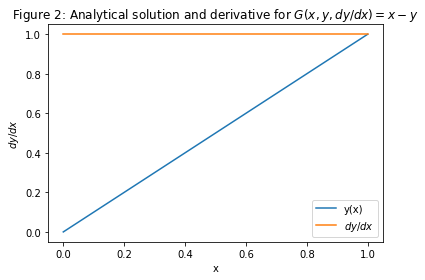

In [5]:
xmin = 0
xmax = 1
n = 100
x = np.linspace(xmin, xmax, n)
y = np.zeros(n)
dy_dx = np.zeros(n)
for i in range(n):
    y[i] = ya(x[i])
    dy_dx[i] = dya_dx(x[i])
plt.xlabel('x')
plt.ylabel('$dy/dx$')
plt.plot(x, y, label = 'y(x)')
plt.plot(x, dy_dx, label = "$dy/dx$")
plt.legend()
plt.title("Figure 2: Analytical solution and derivative for $G(x,y,dy/dx)=x-y$");

Define the differential equation itself, and its derivatives.

In [6]:
# Define the original differential equation:
def G(x, y, dy_dx):
    return x - y

# Define the 1st y-partial derivative of the differential equation.
def dG_dy(x, y, dy_dx):
    return -1

# Define the 1st dy/dx-partial derivative of the differential equation.
def dG_dydx(x, y, dy_dx):
    return 0

The initial condition is:

In [7]:
A = 0

## Create the training data

For the purposes of this example, an evenly-spaced set of training points will be used to train the neural network.

In [8]:
nt = 10
xt = np.linspace(xmin, xmax, num = nt)

Note that repeated runs of the same ODE will usually result in slightly different solutions, due to the random number generator. To ensure repeatable results, seed the random number generator with a fixed value before each run.

## Train the model to solve the ODE

We can now train the network. The call below shows the minimum arguments required to call the `nnode1()` function. All tunable parameters (learning rate `eta`, hidden layer size `H`, number of training epochs `max_epochs` are given default values ($0.01$, $10$, $1000$, respectively). The training function returns the estimated values of $y$ and $\frac {dy}{dx}$ at the training points. When the `verbose` option is set to `True`, the function prints out the epoch number and current value of the mean-squared error of $G_i$.

In [9]:
from nnode1 import nnode1
np.random.seed(0)
(yt, dyt_dx) = nnode1(G, A, dG_dy, dG_dydx, xt, verbose = True)

0 1.61164509281743
1 0.8732334213518763
2 0.47609659903156043
3 0.2614963987155287
4 0.14517210147883283
5 0.08198578466992676
6 0.047613428964406596
7 0.028895712566020575
8 0.018694573850117968
9 0.013131056752996348
10 0.010094598849916196
11 0.008435806084766358
12 0.007528329679566309
13 0.007030691621726693
14 0.006756660100527487
15 0.006604645195231272
16 0.0065192194470795614
17 0.006470137646676288
18 0.006440894216342488
19 0.006422480985955197
20 0.0064099813398582044
21 0.006400711701362612
22 0.006393207279481022
23 0.006386668519383673
24 0.006380658975758646
25 0.006374940406027238
26 0.006369382758225817
27 0.006363915037990171
28 0.006358498488872124
29 0.006353111952376808
30 0.006347743876407717
31 0.006342387952857359
32 0.006337040736247434
33 0.006331700343780523
34 0.006326365745714215
35 0.00632103637798357
36 0.0063157119307349395
37 0.006310392232888235
38 0.006305077189120184
39 0.006299766745464081
40 0.006294460870531019
41 0.006289159545258682
42 0.006283

341 0.00488559715445064
342 0.0048814868454506305
343 0.004877379978719402
344 0.004873276551209436
345 0.004869176559876244
346 0.004865080001678649
347 0.004860986873578695
348 0.0048568971725414245
349 0.004852810895535283
350 0.004848728039531726
351 0.004844648601505412
352 0.004840572578434345
353 0.00483649996729937
354 0.004832430765084746
355 0.004828364968777727
356 0.004824302575368885
357 0.0048202435818517735
358 0.004816187985223147
359 0.0048121357824829555
360 0.004808086970634186
361 0.004804041546682998
362 0.004799999507638695
363 0.004795960850513694
364 0.004791925572323372
365 0.004787893670086581
366 0.00478386514082485
367 0.0047798399815631235
368 0.004775818189329312
369 0.004771799761154431
370 0.004767784694072619
371 0.004763772985121076
372 0.004759764631340086
373 0.004755759629773012
374 0.004751757977466287
375 0.004747759671469441
376 0.0047437647088350255
377 0.0047397730866186455
378 0.004735784801879078
379 0.0047317998516779956
380 0.00472781823308

671 0.00369939606882308
672 0.0036962733475064246
673 0.0036931532136941884
674 0.0036900356651956975
675 0.003686920699822317
676 0.003683808315387629
677 0.003680698509707172
678 0.003677591280598734
679 0.003674486625881967
680 0.0036713845433787662
681 0.003668285030913038
682 0.0036651880863107895
683 0.003662093707400091
684 0.0036590018920110703
685 0.0036559126379759133
686 0.0036528259431289206
687 0.003649741805306394
688 0.003646660222346745
689 0.0036435811920903644
690 0.0036405047123798198
691 0.003637430781059616
692 0.0036343593959763647
693 0.003631290554978699
694 0.0036282242559173526
695 0.0036251604966449852
696 0.003622099275016413
697 0.0036190405888884315
698 0.0036159844361198634
699 0.003612930814571618
700 0.003609879722106593
701 0.0036068311565896675
702 0.003603785115887868
703 0.0036007415978701364
704 0.003597700600407437
705 0.0035946621213728525
706 0.003591626158641321
707 0.003588592710089962
708 0.003585561773597815
709 0.0035825333470458865
710 0.0

Plot the results of this training run.

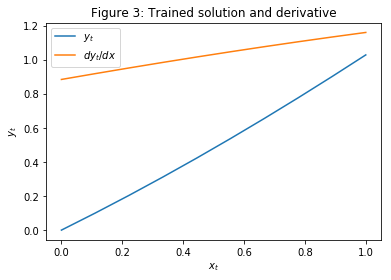

In [10]:
plt.plot(xt, yt, label = '$y_t$')
plt.plot(xt, dyt_dx, label = '$dy_t/dx$')
plt.xlabel('$x_t$')
plt.ylabel('$y_t$')
plt.legend()
plt.title("Figure 3: Trained solution and derivative");

Plot the error in the estimated solution and derivatives.

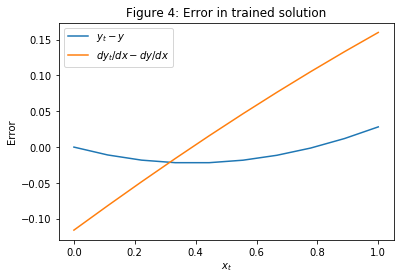

In [11]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 4: Error in trained solution");

Now try repeating the analysis with a larger number of hidden nodes, and plot the error.

In [12]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(G, A, dG_dy, dG_dydx, xt, nhid = 20)

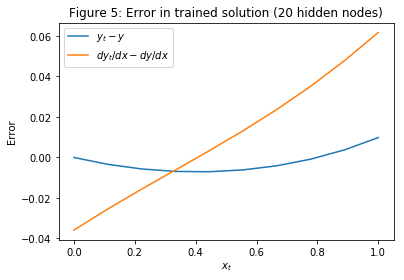

In [13]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 5: Error in trained solution (20 hidden nodes)");

Now try repeating the analysis with a slightly larger learning rate, and plot the error.

In [14]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(G, A, dG_dy, dG_dydx, xt, nhid = 20, eta = 0.02)

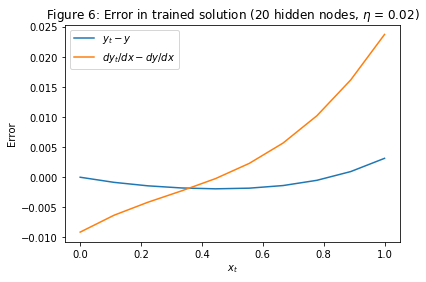

In [15]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 6: Error in trained solution (20 hidden nodes, $\eta$ = 0.02)");

Now try repeating the analysis with a larger number of training epochs, and plot the error.

In [16]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(G, A, dG_dy, dG_dydx, xt, nhid = 20, eta = 0.02, maxepochs = 2000)

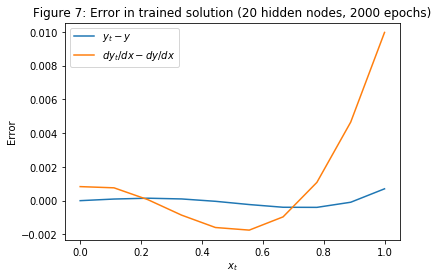

In [17]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ya(xt[i])
    dy_dx[i] = dya_dx(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 7: Error in trained solution (20 hidden nodes, 2000 epochs)");

## Using a ODE definition module

Rather than entering ODE definitions in this notebook, the required definitions can be entered in a separate Python module, and imported. For example, the previous code is also encapsulated in the file `ode00.py`, and can be imported:

In [18]:
import ode00

We can now run the net using the information in this module.

In [19]:
np.random.seed(0)
(yt, dyt_dx) = nnode1(ode00.Gf, ode00.ic, ode00.dG_dyf, ode00.dG_dydxf, xt)

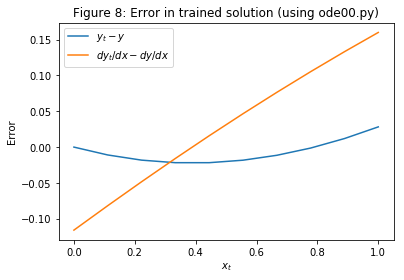

In [20]:
y = np.zeros(nt)
dy_dx = np.zeros(nt)
for i in range(nt):
    y[i] = ode00.yaf(xt[i])
    dy_dx[i] = ode00.dya_dxf(xt[i])
plt.plot(xt, yt - y, label = '$y_t-y$')
plt.plot(xt, dyt_dx - dy_dx, label = '$dy_t/dx-dy/dx$')
plt.xlabel('$x_t$')
plt.ylabel('Error')
plt.legend()
plt.title("Figure 8: Error in trained solution (using ode00.py)");